<a href="https://colab.research.google.com/github/gfwx/ml-capstone-project/blob/main/PV_LSTM_model_ml_capstone_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Project Configuration
## Steps Involved
1. Loading the initial datasets
2. Importing modules

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Plant_1_Generation_Data.csv to Plant_1_Generation_Data.csv
Saving Plant_1_Weather_Sensor_Data.csv to Plant_1_Weather_Sensor_Data.csv
Saving Plant_2_Generation_Data.csv to Plant_2_Generation_Data.csv
Saving Plant_2_Weather_Sensor_Data.csv to Plant_2_Weather_Sensor_Data.csv


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sys

# 1. Data Configuration
## Steps Involved
1. Loading data from datasets
2. Formatting and indexing datasets on timestamps
3. Merging generation and weather (internal & external factors)

In [ ]:

FILES = {
    'p1_gen': 'Plant_1_Generation_Data.csv',
    'p1_weather': 'Plant_1_Weather_Sensor_Data.csv',
    'p2_gen': 'Plant_2_Generation_Data.csv',
    'p2_weather': 'Plant_2_Weather_Sensor_Data.csv'
}

def load_data(file_dict):
    dataframes = {}

    for key, file_name in file_dict.items():
        print(f"Loading '{file_name}' as '{key}'...")
        dataframes[key] = pd.read_csv(file_name)

    print("All files loaded successfully.\n")
    return dataframes


def process_plant_data_individual_inverters(gen_df, weather_df, p1_date_format=False):
    """
    Cleans and merges generation and weather data for a single plant, keeping individual inverter data intact.
    """

    if p1_date_format:
        gen_df['DATE_TIME'] = pd.to_datetime(gen_df['DATE_TIME'], format='%d-%m-%Y %H:%M')
    else:
        gen_df['DATE_TIME'] = pd.to_datetime(gen_df['DATE_TIME'])


    weather_df['DATE_TIME'] = pd.to_datetime(weather_df['DATE_TIME'])
    weather_df = weather_df.drop(columns=['SOURCE_KEY'], errors='ignore')

    plant_df = pd.merge(
        gen_df,
        weather_df,
        on=['DATE_TIME', 'PLANT_ID'],
        how='inner'
    )

    print(f"Merged plant data shape (per-inverter): {plant_df.shape}\n")
    return plant_df

def clean_dataframe(df, plant_name):
    print(f"\n--- Cleaning {plant_name} DataFrame ---")

    nan_count = df.isnull().sum().sum()
    print(f"Found {nan_count} missing (NaN) values.")
    if nan_count > 0:
        df = df.dropna()
        print(f"Dropped NaN rows. New shape: {df.shape}")


    return df

def generate_df_report(df, title):
  print("="*50)
  print(f"{title} Report")
  print("="*50)
  print(f"Final Shape: {df.shape}")
  print("\nDescriptive Statistics:\n")
  print(df.describe())
  print("\n DF Head:\n")
  print(df.head())

In [ ]:

dfs = load_data(FILES)
plant_1_df = process_plant_data_individual_inverters(
    dfs['p1_gen'],
    dfs['p1_weather'],
    p1_date_format=True
)


plant_2_df = process_plant_data_individual_inverters(
    dfs['p2_gen'],
    dfs['p2_weather']
)


plant_1_df_cleaned = clean_dataframe(plant_1_df, "Plant 1")
plant_2_df_cleaned = clean_dataframe(plant_2_df, "Plant 2")

generate_df_report(plant_1_df_cleaned, "Plant 1")
generate_df_report(plant_2_df_cleaned, "Plant 2")


try:
    plant_1_df_cleaned.to_csv('plant_1_data_with_weather.csv', index=False)
    print("\n\nSuccessfully saved final data to 'plant_1_data_with_weather.csv'")

    plant_2_df_cleaned.to_csv('plant_2_data_with_weather.csv', index=False)
    print("Successfully saved final data to 'plant_2_data_with_weather.csv'")

except Exception as e:
    print(f"\nWarning: Could not save final CSVs. Error: {e}")

Loading 'Plant_1_Generation_Data.csv' as 'p1_gen'...
Loading 'Plant_1_Weather_Sensor_Data.csv' as 'p1_weather'...
Loading 'Plant_2_Generation_Data.csv' as 'p2_gen'...
Loading 'Plant_2_Weather_Sensor_Data.csv' as 'p2_weather'...
All files loaded successfully.

Merged plant data shape (per-inverter): (68774, 10)

Merged plant data shape (per-inverter): (67698, 10)


--- Cleaning Plant 1 DataFrame ---
Found 0 missing (NaN) values.

--- Cleaning Plant 2 DataFrame ---
Found 0 missing (NaN) values.
Plant 1 Report
Final Shape: (68774, 10)

Descriptive Statistics:

                           DATE_TIME   PLANT_ID      DC_POWER      AC_POWER   DAILY_YIELD   TOTAL_YIELD  AMBIENT_TEMPERATURE  MODULE_TEMPERATURE   IRRADIATION
count                          68774    68774.0  68774.000000  68774.000000  68774.000000  6.877400e+04         68774.000000        68774.000000  68774.000000
mean   2020-06-01 08:02:38.161514240  4135001.0   3147.177450    307.778375   3295.834644  6.978728e+06            25.

# 2. Preparing the combined training dataset
## Steps Involved
1. Loading the right file (plant_1_data_with_weather.csv)
2. Dropping duplicates
3. Deleting outliers / edgecase data (for both non-generating and generating subsets)
4.  Generating a final dataset clear of outliers, duplicates and NaNs.

In [ ]:
FILE_NAME = 'plant_1_data_with_weather.csv' # File to load

# --- IQR Configuration ---
IQR_COLUMNS = [
    'DC_POWER',
    'AC_POWER',
    'AMBIENT_TEMPERATURE',
    'MODULE_TEMPERATURE',
    'IRRADIATION'
]

# --- Load Data ---
print(f"--- Loading EDA data from '{FILE_NAME}' ---")
try:
    df_plant_01 = pd.read_csv(FILE_NAME, parse_dates=['DATE_TIME'])
    print("Data loaded successfully.")
    print(f"Initial Shape (before cleaning): {df.shape}")
except FileNotFoundError:
    print(f"File not found: {FILE_NAME}")
    sys.exit(1)
except Exception as e:
    print(f"An error occurred: {e}")
    sys.exit(1)


initial_rows = df_plant_01.shape[0]
df_plant_01 = df_plant_01.drop_duplicates(subset=['DATE_TIME', 'SOURCE_KEY'], keep='first')
rows_dropped = initial_rows - df_plant_01.shape[0]

print(f"Removed {rows_dropped} duplicate rows (DATE_TIME + SOURCE_KEY).")
if df_plant_01.empty:
    print("DataFrame is empty after dropping duplicates. Exiting.")
    sys.exit(0)


--- Loading EDA data from 'plant_1_data_with_weather.csv' ---
Data loaded successfully.
Initial Shape (before cleaning): (68774, 9)
Removed 0 duplicate rows (DATE_TIME + SOURCE_KEY).


In [ ]:
# Separate generating from non-generating data
non_generating_mask = (df_plant_01['AC_POWER'] <= 0.1) | (df_plant_01['IRRADIATION'] <= 0)
non_generating_df = df_plant_01[non_generating_mask]
generating_df = df_plant_01[~non_generating_mask]


if not generating_df.empty:
    outlier_mask_gen = pd.Series(False, index=generating_df.index)

    # Find columns that actually exist in the DataFrame to check
    valid_cols = [col for col in IQR_COLUMNS if col in generating_df.columns]
    print(f"Calculating IQR outliers for: {', '.join(valid_cols)}")

    for col in valid_cols:
        Q1 = generating_df[col].quantile(0.25)
        Q3 = generating_df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - (1.5 * IQR)
        upper_bound = Q3 + (1.5 * IQR)

        col_mask_gen = (generating_df[col] < lower_bound) | (generating_df[col] > upper_bound)
        outlier_mask_gen = outlier_mask_gen | col_mask_gen

    num_outliers = outlier_mask_gen.sum()
    total_generating_rows = generating_df.shape[0]
    outlier_percentage = (num_outliers / total_generating_rows) * 100

    print(f"Identified {num_outliers} outliers ({outlier_percentage:.2f}% of *generating* data).")
    cleaned_generating_df = generating_df[~outlier_mask_gen]


if not non_generating_df.empty:
    outlier_mask_gen = pd.Series(False, index=non_generating_df.index)
    valid_cols = [col for col in IQR_COLUMNS if col in generating_df.columns]
    print(f"Calculating IQR outliers for: {', '.join(valid_cols)}")

    for col in valid_cols:
        Q1 = non_generating_df[col].quantile(0.25)
        Q3 = non_generating_df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - (1.5 * IQR)
        upper_bound = Q3 + (1.5 * IQR)

        col_mask = (non_generating_df[col] < lower_bound) | (non_generating_df[col] > upper_bound)
        outlier_mask = outlier_mask | col_mask

    num_outliers = outlier_mask.sum()
    total_non_generating_rows = non_generating_df.shape[0]
    cleaned_non_generating_df = non_generating_df[~outlier_mask]


final_training_df = pd.concat([cleaned_non_generating_df, cleaned_generating_df])
final_training_df.set_index('DATE_TIME').sort_index(inplace=True)

generate_df_report(final_training_df, "Final Training Set")

# Check if data is empty after loading
if final_training_df.empty:
    print("The DataFrame is empty (possibly all data was 'zero-value' and removed).")
    print("Cannot proceed with plotting.")
    sys.exit(0)

Calculating IQR outliers for: DC_POWER, AC_POWER, AMBIENT_TEMPERATURE, MODULE_TEMPERATURE, IRRADIATION
Identified 0 outliers (0.00% of *generating* data).
Calculating IQR outliers for: DC_POWER, AC_POWER, AMBIENT_TEMPERATURE, MODULE_TEMPERATURE, IRRADIATION
Final Training Set Report
Final Shape: (65901, 10)

Descriptive Statistics:

                           DATE_TIME   PLANT_ID      DC_POWER      AC_POWER   DAILY_YIELD   TOTAL_YIELD  AMBIENT_TEMPERATURE  MODULE_TEMPERATURE   IRRADIATION
count                          65901    65901.0  65901.000000  65901.000000  65901.000000  6.590100e+04         65901.000000        65901.000000  65901.000000
mean   2020-06-01 11:59:16.803387136  4135001.0   3284.380843    321.196188   3228.958721  6.980518e+06            25.558407           31.543770      0.241683
min              2020-05-15 00:00:00  4135001.0      0.000000      0.000000      0.000000  6.183645e+06            20.426455           18.140415      0.000000
25%              2020-05-24 0

/tmp/ipython-input-1794158993.py:51: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cleaned_non_generating_df = non_generating_df[~outlier_mask]


# 3. Dataset Visualisation
## Steps Involved
1. Finding a valid period of data  (7-days) in the final training dataset
2. Resampling by hour-based samples via resample
3. Visualize Time series data of AC Power (kW), Irradiation (kW/$m^2$), Module Temperature based on mean of the hourly samples
4. Plot hourly distribution boxplots of all features
5. Visualsing the correlation matrix of the training dataset

Could not plot line graph: unsupported operand type(s) for +: 'int' and 'Timedelta'
Could not plot boxplots: 'Index' object has no attribute 'hour'


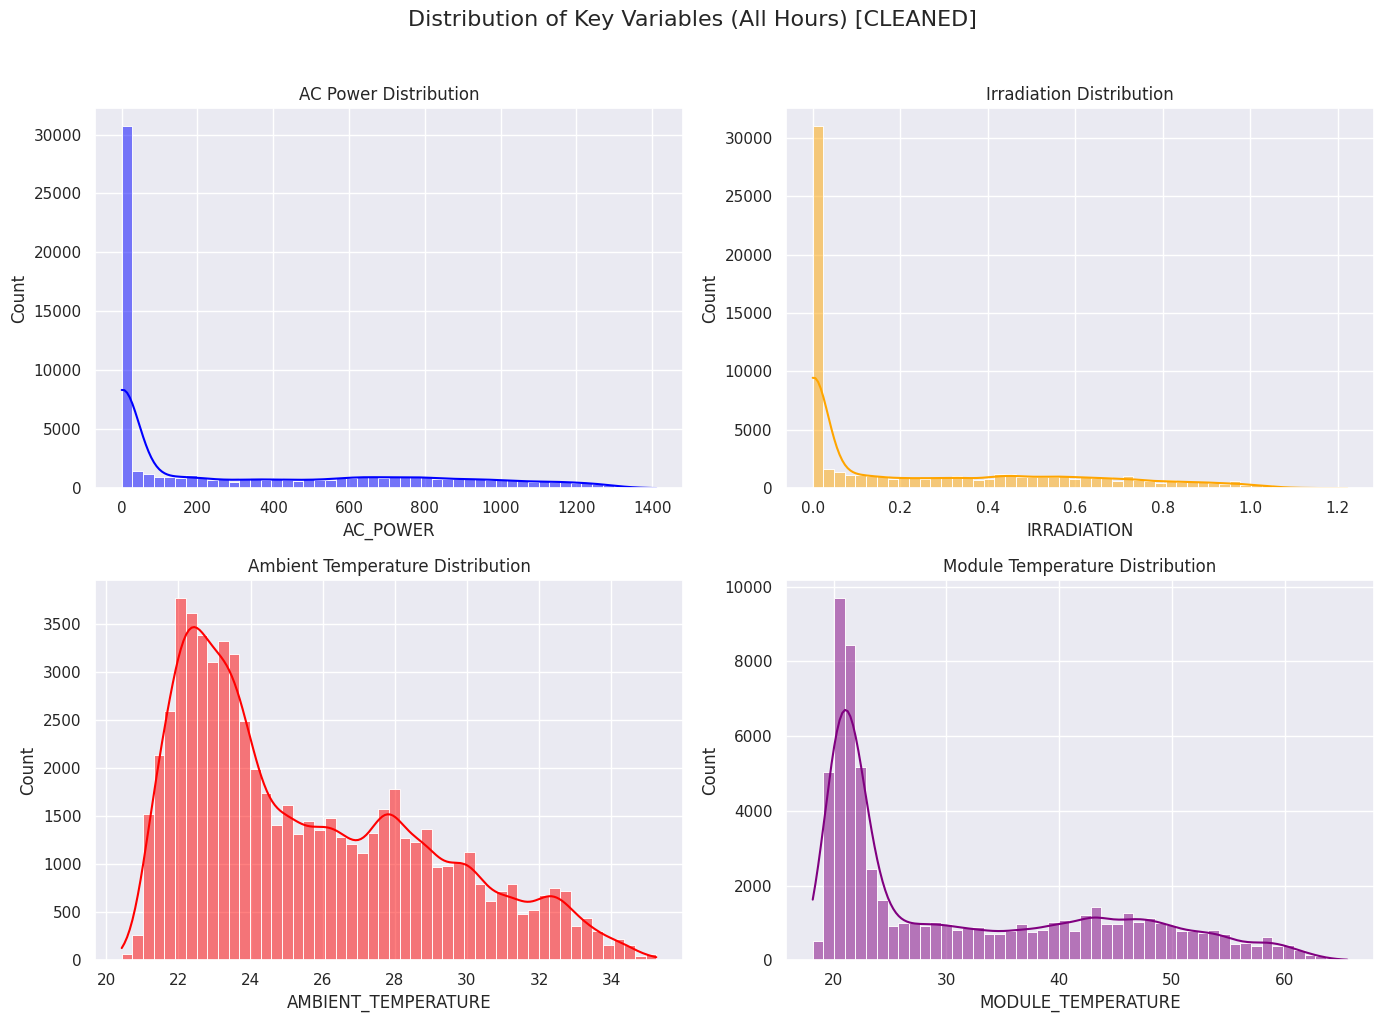

/tmp/ipython-input-1420301005.py:102: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  corr_df = final_training_df[~non_generating_mask]


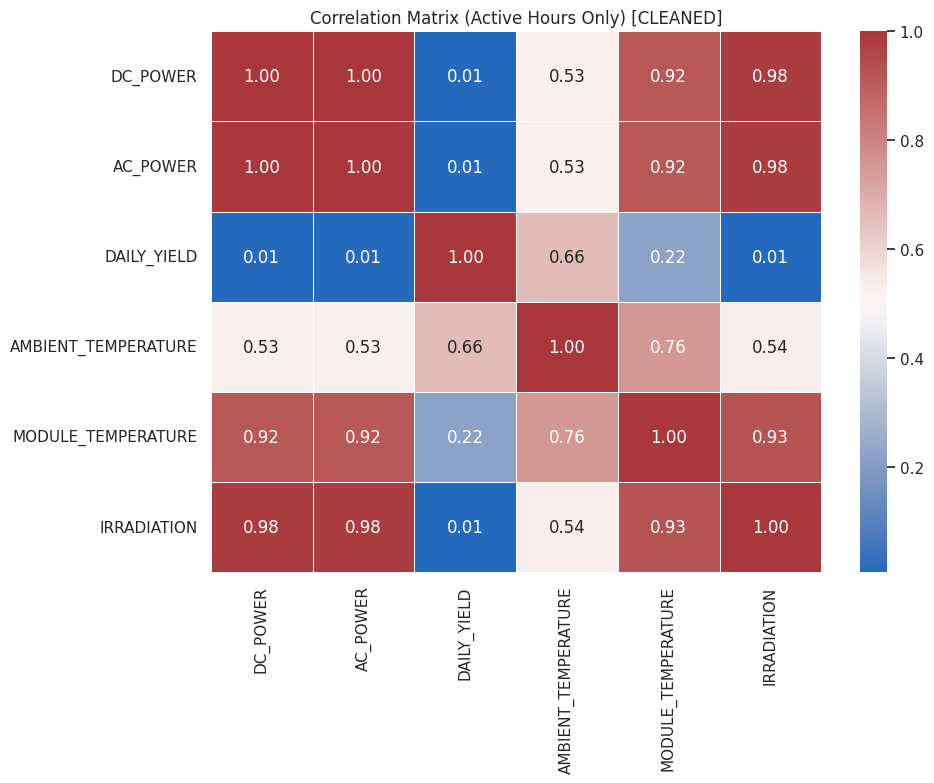

In [ ]:
# Find a valid 7-day period in the data
try:
    if final_training_df.shape[0] < 7 * 24: # Not enough data for a full week
        start_date = final_training_df.index.min()
        end_date = final_training_df.index.max()
    else:
        start_date = final_training_df.index.min() + pd.Timedelta(days=7)
        end_date = start_date + pd.Timedelta(days=7)

    # In case the dataset has gaps
    if not final_training_df.loc[start_date:end_date].empty:
        df_sample = final_training_df.loc[start_date:end_date]


    else: # Fallback to first 7 days
        start_date = final_training_df.index.min()
        end_date = start_date + pd.Timedelta(days=7)
        df_sample = final_training_df.loc[start_date:end_date]

    # Data is per-inverter, so average them for a cleaner plot
    df_sample_avg = df_sample.resample('H').mean(numeric_only=True)

    fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True)
    fig.suptitle(f'Time Series - Sample ({start_date.date()} to {end_date.date()}) [CLEANED]', fontsize=16, y=1.02)

    df_sample_avg['AC_POWER'].plot(ax=axes[0], title='Average AC Power', color='blue', legend=True)
    axes[0].set_ylabel('AC Power (kW)')

    df_sample_avg['IRRADIATION'].plot(ax=axes[1], title='Average Irradiation', color='orange', legend=True)
    axes[1].set_ylabel('Irradiation (kW/m²)')

    df_sample_avg['MODULE_TEMPERATURE'].plot(ax=axes[2], title='Average Module Temperature', color='red', legend=True)
    axes[2].set_ylabel('Temperature (°C)')

    plt.xlabel('Date and Time')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Could not plot line graph: {e}")


try:
    df_plot = final_training_df.copy()
    df_plot['hour'] = df_plot.index.hour

    fig, axes = plt.subplots(3, 1, figsize=(15, 15), sharex=True)
    fig.suptitle('Hourly Distribution Boxplots (All Hours) [CLEANED]', fontsize=16, y=1.02)

    sns.boxplot(ax=axes[0], x='hour', y='AC_POWER', data=df_plot)
    axes[0].set_title('AC Power Distribution by Hour')
    axes[0].set_ylabel('AC Power (kW)')

    sns.boxplot(ax=axes[1], x='hour', y='IRRADIATION', data=df_plot)
    axes[1].set_title('Irradiation Distribution by Hour')
    axes[1].set_ylabel('Irradiation (W/m²)')

    sns.boxplot(ax=axes[2], x='hour', y='MODULE_TEMPERATURE', data=df_plot)
    axes[2].set_title('Module Temperature Distribution by Hour')
    axes[2].set_ylabel('Temperature (°C)')
    axes[2].set_xlabel('Hour of the Day')

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Could not plot boxplots: {e}")



try:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Distribution of Key Variables (All Hours) [CLEANED]', fontsize=16, y=1.02)

    sns.histplot(final_training_df['AC_POWER'], kde=True, ax=axes[0, 0], color='blue', bins=50)
    axes[0, 0].set_title('AC Power Distribution')

    sns.histplot(final_training_df['IRRADIATION'], kde=True, ax=axes[0, 1], color='orange', bins=50)
    axes[0, 1].set_title('Irradiation Distribution')

    sns.histplot(final_training_df['AMBIENT_TEMPERATURE'], kde=True, ax=axes[1, 0], color='red', bins=50)
    axes[1, 0].set_title('Ambient Temperature Distribution')

    sns.histplot(final_training_df['MODULE_TEMPERATURE'], kde=True, ax=axes[1, 1], color='purple', bins=50)
    axes[1, 1].set_title('Module Temperature Distribution')

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Could not plot histograms: {e}")


try:
    numeric_cols = [
        'DC_POWER', 'AC_POWER', 'DAILY_YIELD',
        'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION'
    ]


    valid_cols = [col for col in numeric_cols if col in final_training_df.columns]
    corr_df = final_training_df[~non_generating_mask]

    if corr_df.empty:
        print("No generating data left to correlate. Skipping heatmap.")
    else:
        corr_matrix = corr_df[valid_cols].corr()

        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='vlag', fmt='.2f', linewidths=0.5)
        plt.title('Correlation Matrix (Active Hours Only) [CLEANED]')
        plt.tight_layout()
        plt.show()

except Exception as e:
    print(f"Could not plot correlation matrix: {e}")

In [ ]:
final_training_df.to_csv('final_training_df.csv', index=False)

# 4. LSTM Data Preprocessing
## Steps Involved
1. A function that loads and preprocesses a dataset (by path), and engineers cyclic (time) data into sinusoidal data

2. Create sequences for LSTM since they also take window size (lookbacks) into account
3. Helper functions to plot LSTM loss and model predictions

In [ ]:
# --- HELPER FUNCTIONS ---

def load_and_preprocess(filename):
    """
    Loads, aggregates, and preprocesses data for a single plant.
    """
    try:
        df = pd.read_csv(filename, parse_dates=['DATE_TIME'])

    except FileNotFoundError:
        sys.exit(1)

    # --- Aggregation ---
    df_agg = df.groupby('DATE_TIME').mean(numeric_only=True)

    # --- Resample & Interpolate ---
    df_resampled = df_agg.resample('15T').mean()
    df_filled = df_resampled.interpolate(method='time')
    df_filled = df_filled.dropna() # Drop any NaNs at the very start

    # --- Feature Engineering (Time) ---
    df_filled['hour'] = df_filled.index.hour
    df_filled['hour_sin'] = np.sin(2 * np.pi * df_filled['hour'] / 24)
    df_filled['hour_cos'] = np.cos(2 * np.pi * df_filled['hour'] / 24)

    return df_filled


def create_sequences(features, target, n_lookback):
    """
    Converts flat data into sequences (windows) for LSTM.
    """
    X, y = [], []
    for i in range(len(features) - n_lookback):
        X.append(features[i:(i + n_lookback)])
        y.append(target[i + n_lookback])
    return np.array(X), np.array(y)

def plot_model_loss(history):
    """Plots the training and validation loss."""
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Training & Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_predictions(y_true, y_pred, title, sample_size=500):

    plt.figure(figsize=(15, 7))
    # Plot a subsample to keep the graph readable
    sample_true = y_true[:sample_size]
    sample_pred = y_pred[:sample_size]

    plt.plot(sample_true, label='Actual AC Power', color='blue', alpha=0.7)
    plt.plot(sample_pred, label='Predicted AC Power', color='red', linestyle='--')

    rmse = np.sqrt(mean_squared_error(sample_true, sample_pred))

    plt.title(f'{title} (Sample of {sample_size} points) | Sample RMSE: {rmse:.2f} kW')
    plt.xlabel('Time Step')
    plt.ylabel('AC Power (kW)')
    plt.legend()
    plt.tight_layout()
    plt.show()

# 5. LSTM Model Training
## Steps Involved
1. Model Configuration
2. Scaling, splitting the data
3. Fitting the model
4. Plot model loss
5. Visualise results

In [ ]:
# Model Configuration
# 3 hours of data (12 steps of 15 min) to predict the next 15 min

N_LOOKBACK_STEPS = 12 # 12 * 15 minutes = 3 hours
N_FEATURES = 5
TARGET_COL = 'AC_POWER'
FEATURES = [
    'AMBIENT_TEMPERATURE',
    'MODULE_TEMPERATURE',
    'IRRADIATION',
    'hour_sin',
    'hour_cos'
]

TEST_SIZE = 0.2
SHUFFLE_DATA = False
BATCH_SIZE = 32
EPOCHS = 50

model = Sequential([
    LSTM(50, activation='relu', input_shape=(N_LOOKBACK_STEPS, N_FEATURES)),
    Dense(25, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 50)             │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,501 (48.83 KB)

 Trainable params: 12,501 (48.83 KB)

 Non-trainable params: 0 (0.00 B)

Training data shape: X=(2601, 12, 5), y=(2601,)
Test data shape: X=(651, 12, 5), y=(651,)
Epoch 1/50


/tmp/ipython-input-1352186351.py:17: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_resampled = df_agg.resample('15T').mean()


82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0556 - val_loss: 0.0066
Epoch 2/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0065 - val_loss: 0.0061
Epoch 3/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0063 - val_loss: 0.0058
Epoch 4/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0060 - val_loss: 0.0056
Epoch 5/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0058 - val_loss: 0.0055
Epoch 6/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0057 - val_loss: 0.0054
Epoch 7/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0056 - val_loss: 0.0053
Epoch 8/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0054 - val_loss: 0.0052
Epoch 9/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0053 - val_loss: 0.0051
Epoch 10/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0053 - val_loss: 0.0050
Epoch 11/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0052 - val_loss: 0.0050
Epoch 12/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0051 - val_loss: 0.00

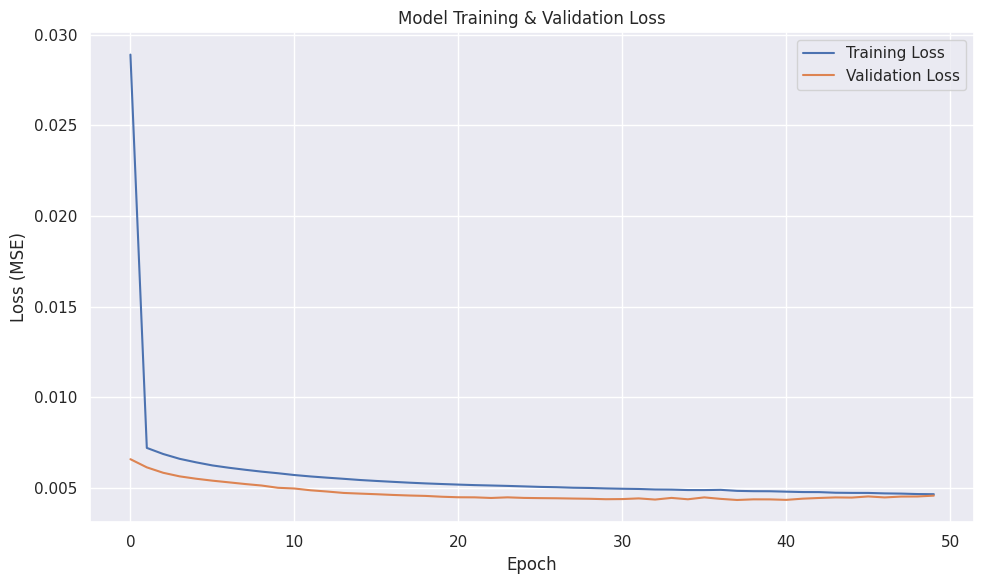

In [ ]:
# Model Training & Fitting
PLANT_1_FILE = 'final_training_df.csv'
df_p1 = load_and_preprocess(PLANT_1_FILE)

feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

scaled_features_p1 = feature_scaler.fit_transform(df_p1[FEATURES])
scaled_target_p1 = target_scaler.fit_transform(df_p1[[TARGET_COL]])


X_p1, y_p1 = create_sequences(scaled_features_p1, scaled_target_p1.flatten(), N_LOOKBACK_STEPS)


split_idx = int(len(X_p1) * (1 - TEST_SIZE))
X_train, X_test = X_p1[:split_idx], X_p1[split_idx:]
y_train, y_test = y_p1[:split_idx], y_p1[split_idx:]

print(f"Training data shape: X={X_train.shape}, y={y_train.shape}")
print(f"Test data shape: X={X_test.shape}, y={y_test.shape}")



history = model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test),
    shuffle=False,
    verbose=1
)

plot_model_loss(history)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Plant 1 Test Set RMSE: 94.40 kW


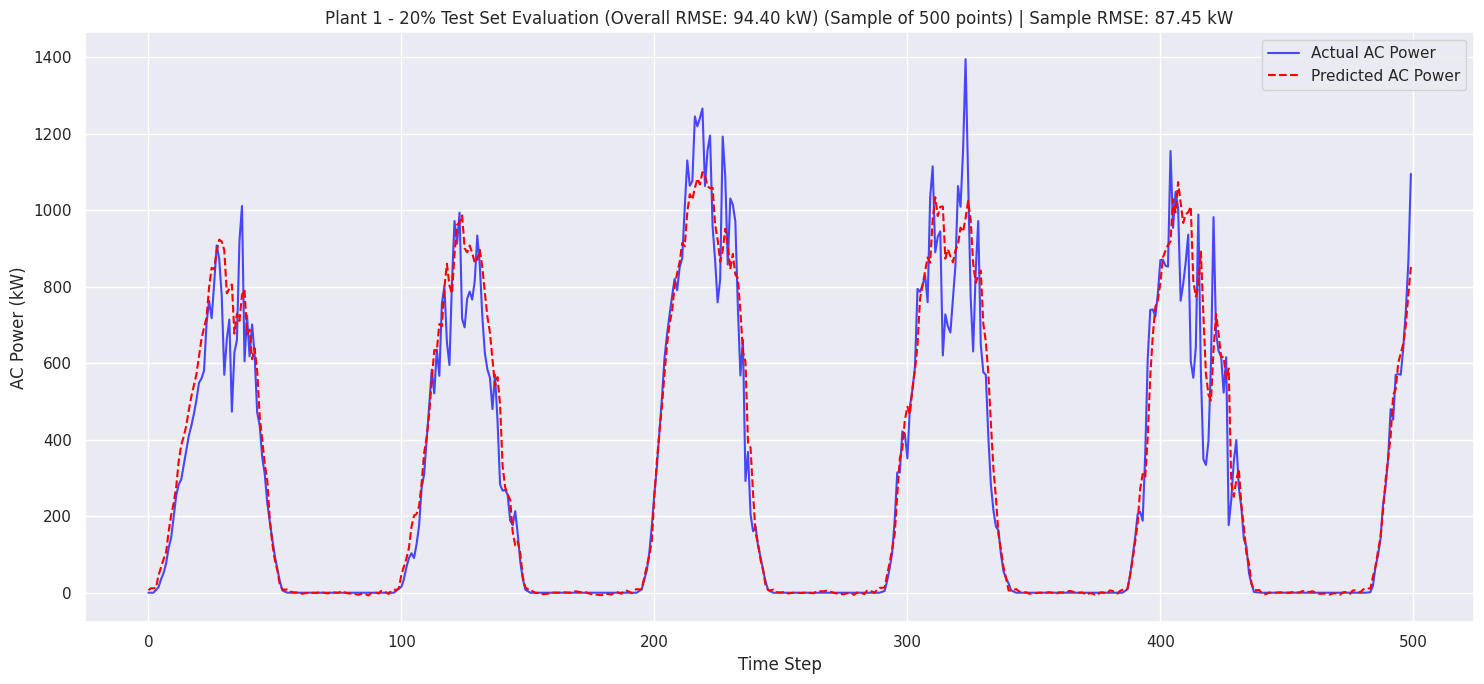

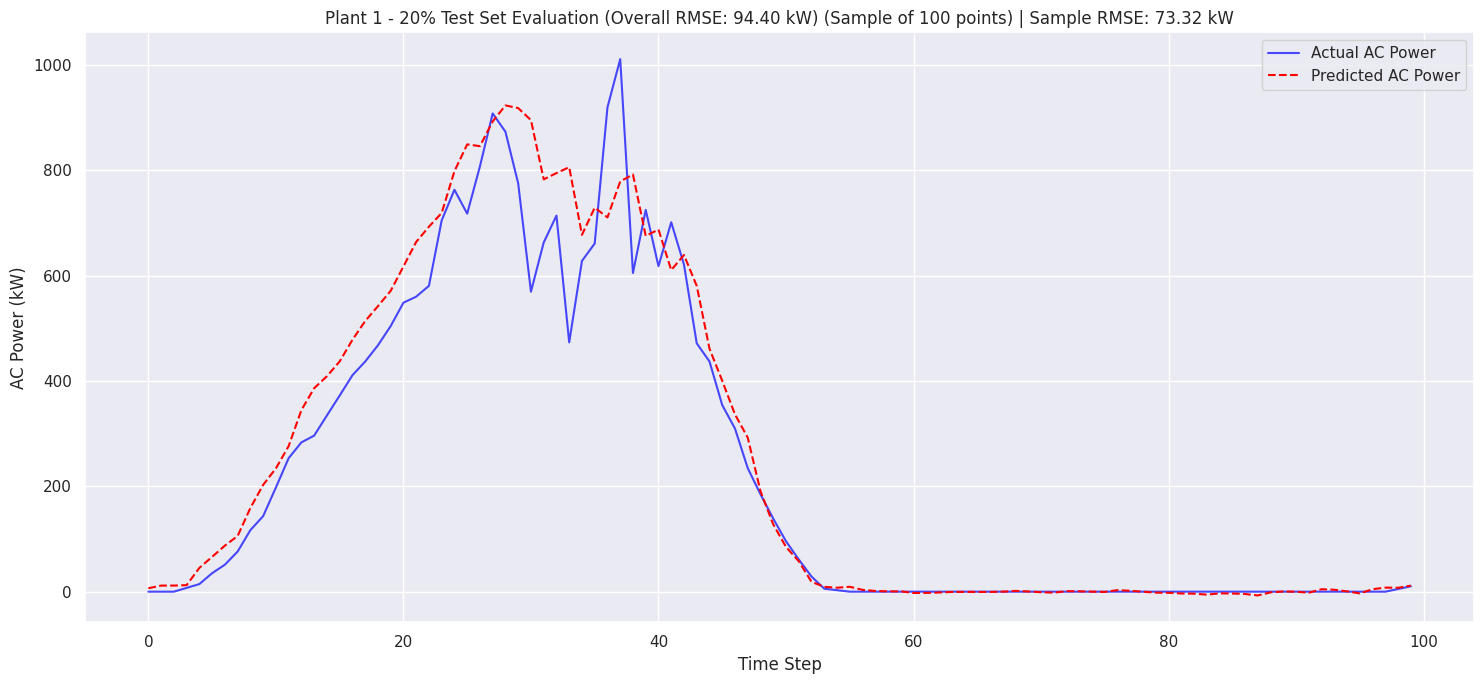

In [ ]:
# Results  (Training -> Testing)
y_pred_test_scaled = model.predict(X_test)

y_pred_test = target_scaler.inverse_transform(y_pred_test_scaled)
y_test_actual = target_scaler.inverse_transform(y_test.reshape(-1, 1))

rmse_p1 = np.sqrt(mean_squared_error(y_test_actual, y_pred_test))
print(f"Plant 1 Test Set RMSE: {rmse_p1:.2f} kW")

plot_predictions(
    y_test_actual,
    y_pred_test,
    f"Plant 1 - 20% Test Set Evaluation (Overall RMSE: {rmse_p1:.2f} kW)",
    500
)


plot_predictions(
    y_test_actual,
    y_pred_test,
    f"Plant 1 - 20% Test Set Evaluation (Overall RMSE: {rmse_p1:.2f} kW)",
    100
)

# 6. Linear Regression Model
## Steps Involved
1. Reshaping samples into 2D input
2. Fitting the model
3. Model prediction


--- Training a Simple Multivariate Linear Regression Model ---
Reshaped Training data shape: X=(2601, 60), y=(2601,)
Reshaped Test data shape: X=(651, 60), y=(651,)

Linear Regression Test Set RMSE: 97.84 kW
Linear Regression Test Set R-squared: 0.93


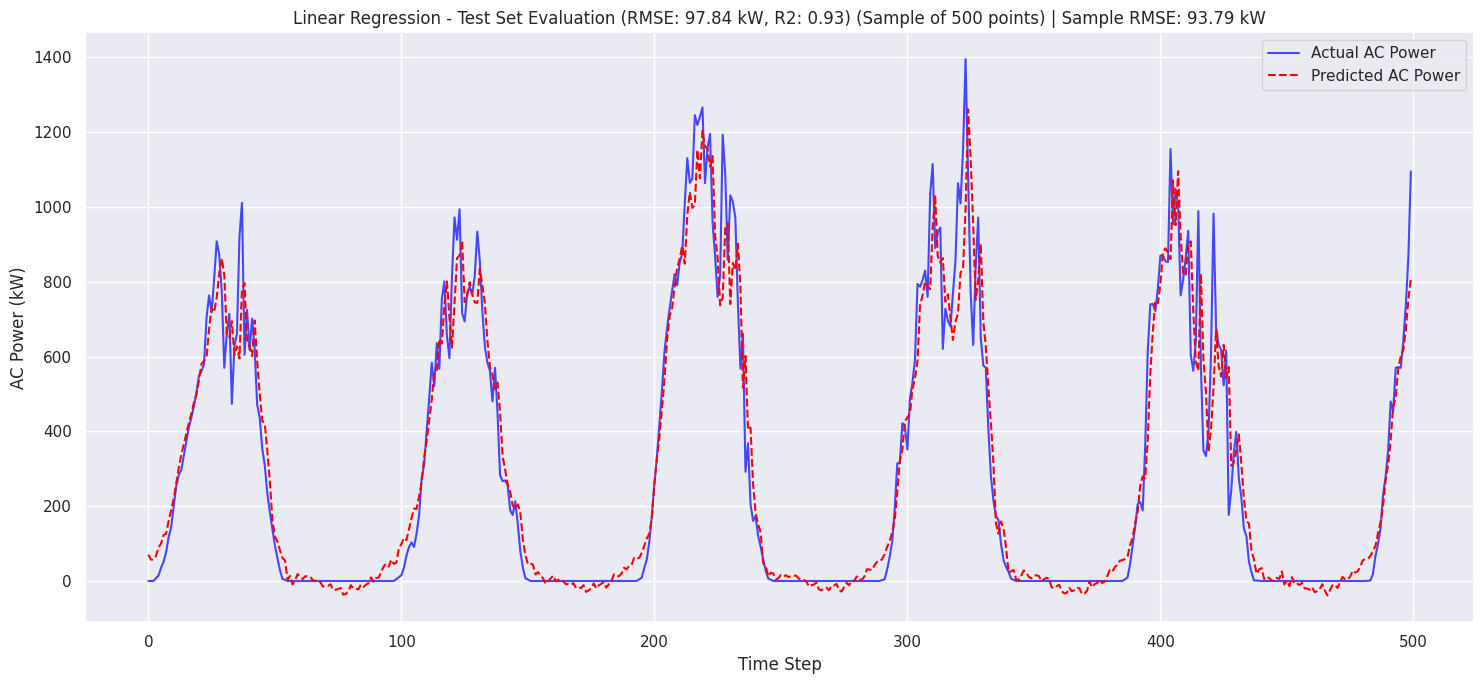

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

print("\n--- Training a Simple Multivariate Linear Regression Model ---")

# Reshape X_train and X_test for Linear Regression
# Linear regression expects 2D input (samples, features)
# LSTM input was 3D (samples, n_lookback_steps, n_features)
# Flatten the n_lookback_steps and n_features dimensions into a single feature vector
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

print(f"Reshaped Training data shape: X={X_train_reshaped.shape}, y={y_train.shape}")
print(f"Reshaped Test data shape: X={X_test_reshaped.shape}, y={y_test.shape}")


linear_model = LinearRegression()
linear_model.fit(X_train_reshaped, y_train)


y_pred_linear_scaled = linear_model.predict(X_test_reshaped)


y_pred_linear = target_scaler.inverse_transform(y_pred_linear_scaled.reshape(-1, 1))
y_test_actual = target_scaler.inverse_transform(y_test.reshape(-1, 1))

rmse_linear = np.sqrt(mean_squared_error(y_test_actual, y_pred_linear))
r2_linear = r2_score(y_test_actual, y_pred_linear)

print(f"\nLinear Regression Test Set RMSE: {rmse_linear:.2f} kW")
print(f"Linear Regression Test Set R-squared: {r2_linear:.2f}")


plot_predictions(
    y_test_actual,
    y_pred_linear,
    f"Linear Regression - Test Set Evaluation (RMSE: {rmse_linear:.2f} kW, R2: {r2_linear:.2f})",
    sample_size=500
)


# 7. Bayesian Ridge Model
## Steps Involved
1. Reshaping samples into 2D input
2. Fitting the model
3. Model prediction


--- Training a Basic Bayesian Ridge Regression Model ---

Bayesian Ridge Regression Test Set RMSE: 97.47 kW
Bayesian Ridge Regression Test Set R-squared: 0.93


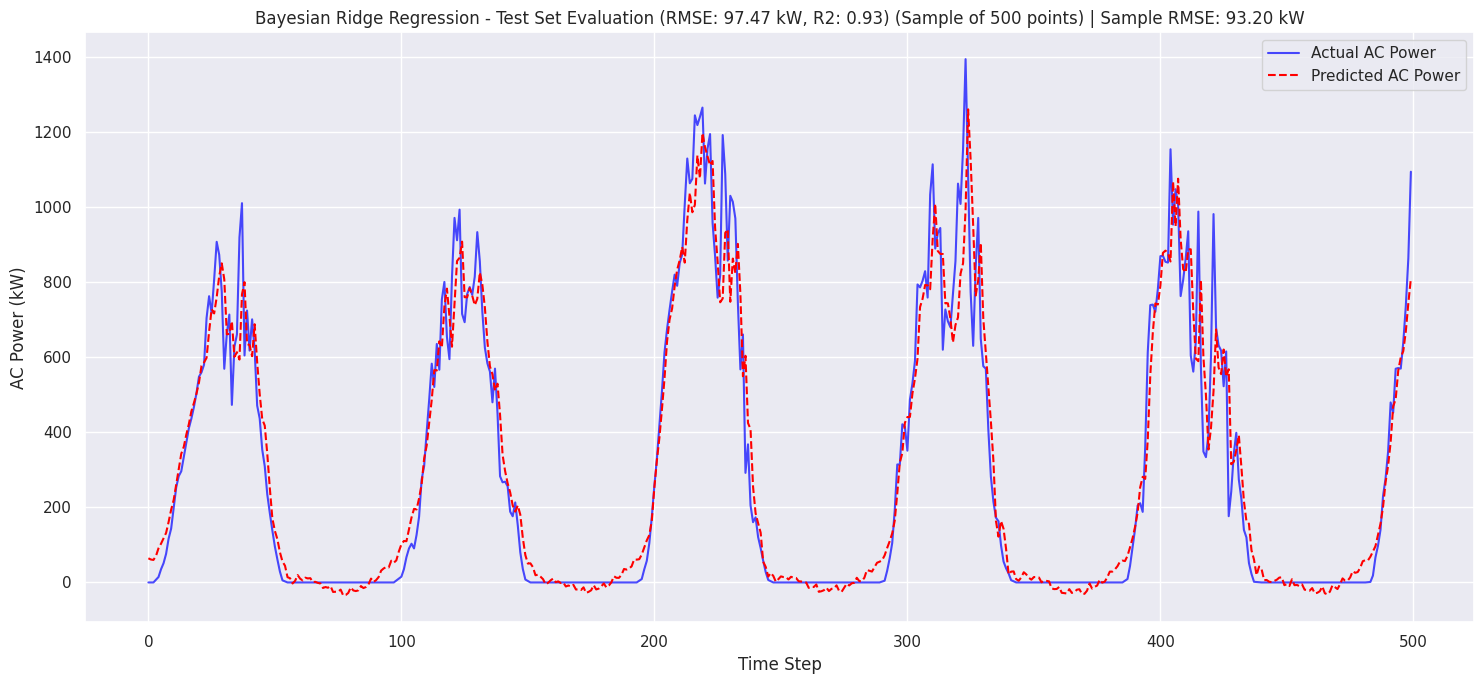

In [ ]:
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error, r2_score

print("\n--- Training a Basic Bayesian Ridge Regression Model ---")

# init and train the Bayesian Ridge model
bayesian_model = BayesianRidge()
bayesian_model.fit(X_train_reshaped, y_train)

# make predictions on the test set (scaled)
y_pred_bayesian_scaled = bayesian_model.predict(X_test_reshaped)
y_pred_bayesian = target_scaler.inverse_transform(y_pred_bayesian_scaled.reshape(-1, 1))

# evaluate the model
rmse_bayesian = np.sqrt(mean_squared_error(y_test_actual, y_pred_bayesian))
r2_bayesian = r2_score(y_test_actual, y_pred_bayesian)

print(f"\nBayesian Ridge Regression Test Set RMSE: {rmse_bayesian:.2f} kW")
print(f"Bayesian Ridge Regression Test Set R-squared: {r2_bayesian:.2f}")

plot_predictions(
    y_test_actual,
    y_pred_bayesian,
    f"Bayesian Ridge Regression - Test Set Evaluation (RMSE: {rmse_bayesian:.2f} kW, R2: {r2_bayesian:.2f})",
    sample_size=500
)


# 8. Ensemble (Simple averaging) Model
## Steps Involved
1. Packing all the models' predictive abilities into a single function that returns both predicted and target (test) data
2. Plot ensemble predictions for the same dataset as above.

In [ ]:
def predict_with_ensemble(input_df, feature_scaler, target_scaler, N_LOOKBACK_STEPS, FEATURES, model, linear_model, bayesian_model):
    """
    Performs ensemble prediction using LSTM, Linear Regression, and Bayesian Ridge models.

    Args:
        input_df (pd.DataFrame): The preprocessed DataFrame with 'DATE_TIME' as index and 'FEATURES' columns.
        feature_scaler (MinMaxScaler): Scaler fitted on training features.
        target_scaler (MinMaxScaler): Scaler fitted on training target.
        N_LOOKBACK_STEPS (int): Number of lookback steps for LSTM sequences.
        FEATURES (list): List of feature column names.
        model (tf.keras.Model): The trained LSTM model.
        linear_model (sklearn.linear_model.LinearRegression): The trained Linear Regression model.
        bayesian_model (sklearn.linear_model.BayesianRidge): The trained Bayesian Ridge model.

    Returns:
        np.ndarray: Ensemble predictions (AC Power) as a 2D NumPy array.
        np.ndarray: The original actual values for comparison (if available in input_df) as a 2D NumPy array, else None.
    """

    # 1. Scale features
    scaled_features = feature_scaler.transform(input_df[FEATURES])

    # 2. Create sequences for LSTM (dummy target is just for function signature)
    # The resulting X_sequences will be shorter than input_df by N_LOOKBACK_STEPS
    X_sequences, _ = create_sequences(scaled_features, np.zeros(len(input_df)), N_LOOKBACK_STEPS)

    # The index for predictions will start after the lookback period
    prediction_index = input_df.index[N_LOOKBACK_STEPS:]

    # 3. LSTM Prediction
    y_pred_lstm_scaled = model.predict(X_sequences, verbose=0)
    y_pred_lstm = target_scaler.inverse_transform(y_pred_lstm_scaled)

    # 4. Prepare data for Linear and Bayesian models (reshape sequences)
    X_linear_input = X_sequences.reshape(X_sequences.shape[0], -1)

    # 5. Linear Regression Prediction
    y_pred_linear_scaled = linear_model.predict(X_linear_input)
    y_pred_linear = target_scaler.inverse_transform(y_pred_linear_scaled.reshape(-1, 1))

    # 6. Bayesian Ridge Prediction
    y_pred_bayesian_scaled = bayesian_model.predict(X_linear_input)
    y_pred_bayesian = target_scaler.inverse_transform(y_pred_bayesian_scaled.reshape(-1, 1))

    # 7. Ensemble Averaging
    y_pred_ensemble = (y_pred_lstm + y_pred_linear + y_pred_bayesian) / 3

    # If the input_df contains the actual target column, return it for evaluation
    if TARGET_COL in input_df.columns:
        actual_target = input_df[TARGET_COL].iloc[N_LOOKBACK_STEPS:].values.reshape(-1, 1)
        # Return the predicted values as a NumPy array and actual values as a NumPy array
        return y_pred_ensemble, actual_target
    else:
        # Return predicted values as a NumPy array and None for actual_target
        return y_pred_ensemble, None


In [ ]:
result, _ = predict_with_ensemble(df_p1, feature_scaler, target_scaler, N_LOOKBACK_STEPS, FEATURES, model, linear_model, bayesian_model)

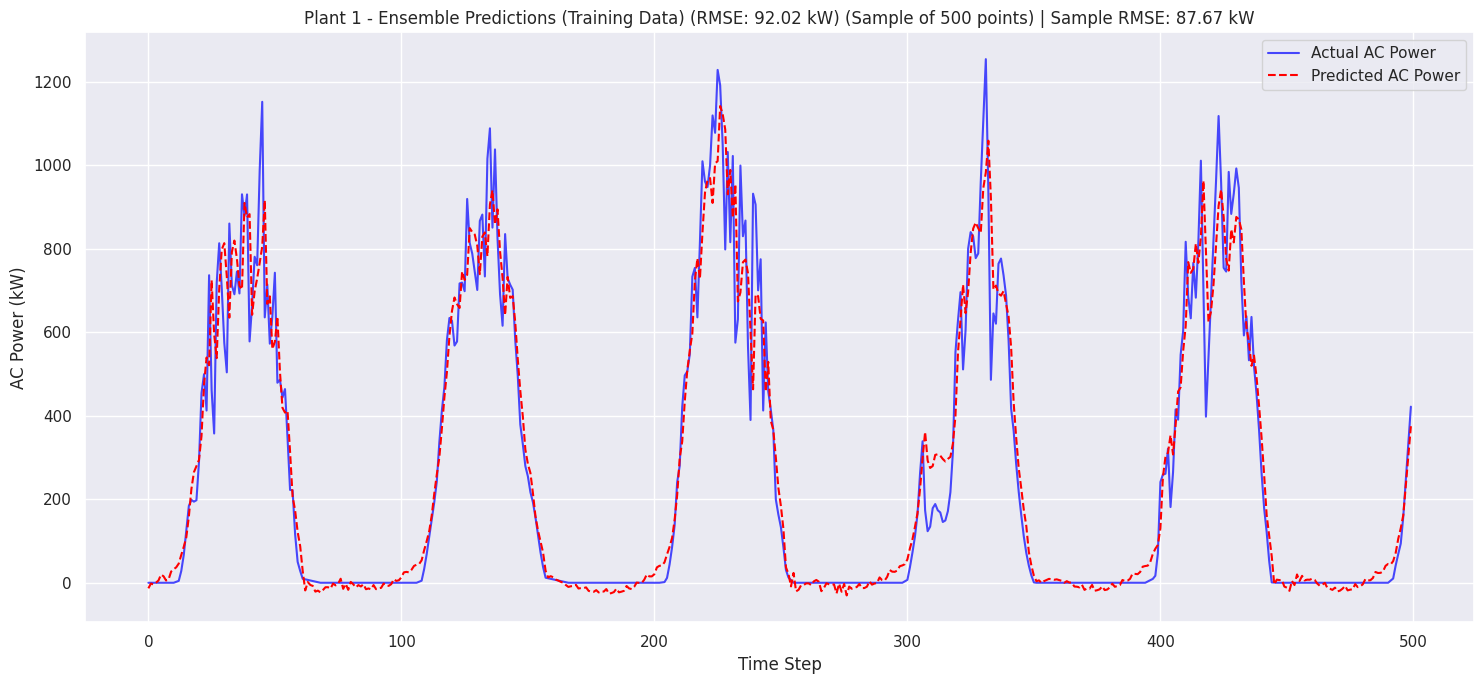

In [ ]:
y_pred_ensemble_p1, y_actual_p1 = predict_with_ensemble(df_p1, feature_scaler, target_scaler, N_LOOKBACK_STEPS, FEATURES, model, linear_model, bayesian_model)

if y_actual_p1 is not None:
    plot_predictions(
        y_actual_p1,
        y_pred_ensemble_p1,
        f"Plant 1 - Ensemble Predictions (Training Data) (RMSE: {rmse_ensemble:.2f} kW)",
        sample_size=500 # Adjust sample size if needed
    )
else:
    print("Could not plot ensemble predictions for df_p1 as actual target values were not available.")

# 9 Advanced Testing 01
## Steps Involved
1. Test with an entirely new dataset - data from plant_2


/tmp/ipython-input-1352186351.py:17: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_resampled = df_agg.resample('15T').mean()


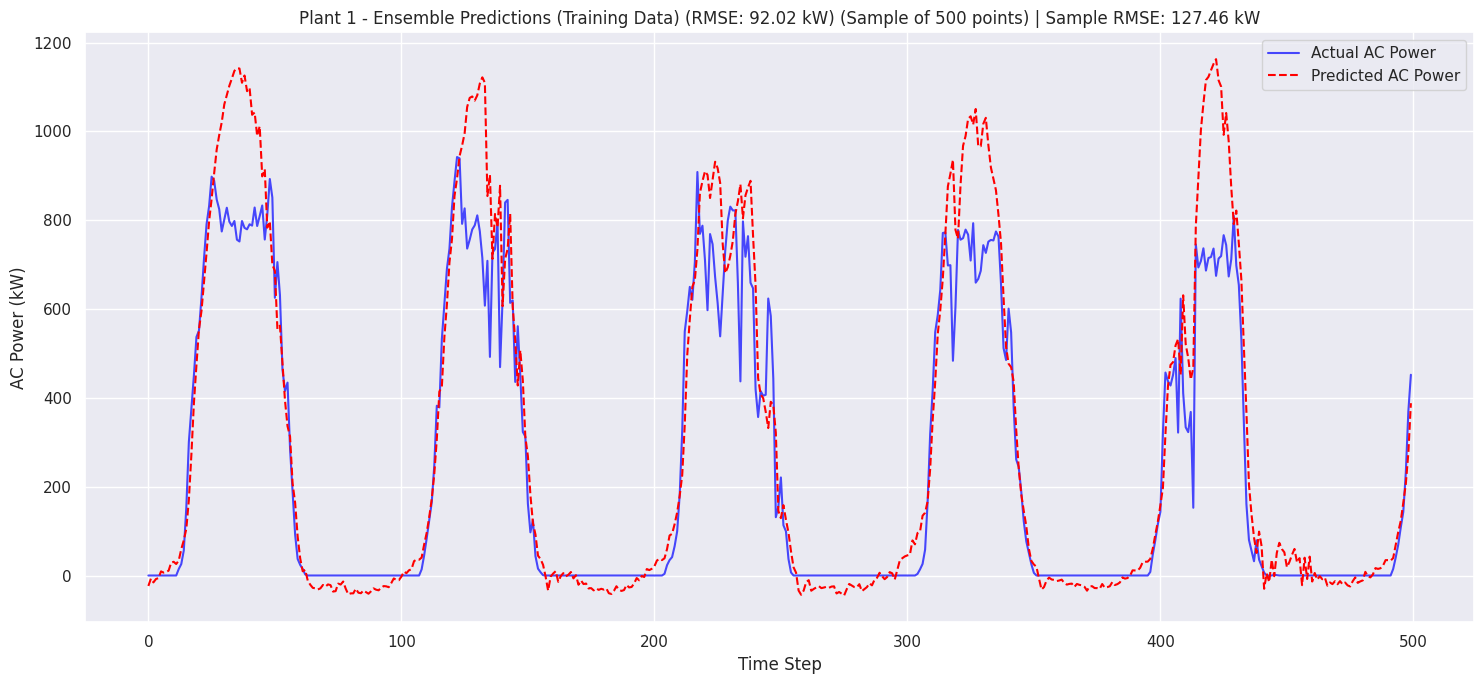

In [ ]:
PLANT_2_FILE = 'plant_2_data_with_weather.csv'
df_p2 = load_and_preprocess(PLANT_2_FILE)


# Uses plant 1's scalers
scaled_features_p2 = feature_scaler.transform(df_p2[FEATURES])
scaled_target_p2 = target_scaler.transform(df_p2[[TARGET_COL]])
X_p2, y_p2 = create_sequences(scaled_features_p2, scaled_target_p2.flatten(), N_LOOKBACK_STEPS)

y_pred_ensemble_p2, y_actual_p2 = predict_with_ensemble(df_p2, feature_scaler, target_scaler, N_LOOKBACK_STEPS, FEATURES, model, linear_model, bayesian_model)
plot_predictions(
    y_actual_p2,
    y_pred_ensemble_p2,
    f"Plant 1 - Ensemble Predictions (Training Data) (RMSE: {rmse_ensemble:.2f} kW)",
    sample_size=500 # Adjust sample size if needed
)

# 10. Advanced Testing 02
## Steps Involved
1. Cleaning, combining and importing a new dataset — HI_SEAS Solar Irradiance Dataset
2. Predicting a wide range of power output based on Solar Irradiance and ambient temperature via ensemble model on HI_SEAS dataset

In [ ]:
# Predicted Solar Irradiance on the HI-SEAS Solar Irradiance Datasets
# The overall dataset is a combination of an ambient temp and a solar radiation dataset.
from google.colab import files
f = files.upload()

Saving solar radiation.csv to solar radiation.csv
Saving temperature.csv to temperature.csv


In [ ]:
solar_irradiation_df = pd.read_csv("solar radiation.csv");
temperature_df = pd.read_csv("temperature.csv")

In [ ]:
solar_irradiation_df.head()

,1,1475315718,2016-09-30,23:55:18,1.270000,Unnamed: 5
0,2,1475315423,2016-09-30,23:50:23,1.25,NaN
1,3,1475315124,2016-09-30,23:45:24,1.25,NaN
2,4,1475314821,2016-09-30,23:40:21,1.25,NaN
3,5,1475314522,2016-09-30,23:35:22,1.27,NaN
4,6,1475314227,2016-09-30,23:30:27,1.29,NaN


In [ ]:
# 1. Cleaning dataset

In [ ]:
solar_irradiation_df.columns = ["INDEX", "TIMESTAMP", "DATE", "TIME", "IRRADIATION", "NAN"]
temperature_df.columns = ["INDEX", "TIMESTAMP", "DATE", "TIME", "AMBIENT_TEMPERATURE", "NAN"]

In [ ]:
# FE
temperature_df.drop(columns=["INDEX", "DATE", "TIME", "NAN"], axis=1, inplace=True)
temperature_df["AMBIENT_TEMPERATURE"] = (temperature_df["AMBIENT_TEMPERATURE"] - 32) * 5 / 9

In [ ]:
# FE 02
solar_irradiation_df.drop(columns=["INDEX", "DATE", "TIME", "NAN"], axis=1, inplace=True)
solar_irradiation_df["IRRADIATION"] /= 1000 # Converting from W to KWh

In [ ]:
final_test_df = pd.merge(temperature_df, solar_irradiation_df, on="TIMESTAMP", how="inner")

In [ ]:
final_test_df.head()

,TIMESTAMP,AMBIENT_TEMPERATURE,IRRADIATION
0,1475315423,8.888889,0.00125
1,1475315124,8.888889,0.00125
2,1475314821,8.888889,0.00125
3,1475314522,8.888889,0.00127
4,1475314227,8.888889,0.00129


In [ ]:
NOCT = 45 # Standard nominal operating temperature


final_test_df["MODULE_TEMPERATURE"] = (final_test_df["AMBIENT_TEMPERATURE"] + (final_test_df["IRRADIATION"] * 1000 / 800) * (NOCT - 20))

In [ ]:
final_test_df.head()

,TIMESTAMP,AMBIENT_TEMPERATURE,IRRADIATION,MODULE_TEMPERATURE
0,1475315423,8.888889,0.00125,8.927951
1,1475315124,8.888889,0.00125,8.927951
2,1475314821,8.888889,0.00125,8.927951
3,1475314522,8.888889,0.00127,8.928576
4,1475314227,8.888889,0.00129,8.929201


In [ ]:
final_test_df.to_csv('test_HI_SEAS.csv', index=False)

In [ ]:
final_test_df['DATE_TIME'] = pd.to_datetime(final_test_df['TIMESTAMP'], unit='s')
final_test_df = final_test_df.set_index('DATE_TIME')
final_test_df['hour'] = final_test_df.index.hour
final_test_df['hour_sin'] = np.sin(2 * np.pi * final_test_df['hour'] / 24)
final_test_df['hour_cos'] = np.cos(2 * np.pi * final_test_df['hour'] / 24)
final_test_df = final_test_df.sort_values(by="TIMESTAMP", ascending=True)
final_test_df.head()

,TIMESTAMP,AMBIENT_TEMPERATURE,IRRADIATION,MODULE_TEMPERATURE,hour,hour_sin,hour_cos
DATE_TIME,,,,,,,
2016-09-01 10:00:08,1472724008,10.555556,0.00258,10.636181,10,0.5,-0.866025
2016-09-01 10:05:10,1472724310,10.555556,0.00283,10.643993,10,0.5,-0.866025
2016-09-01 10:20:06,1472725206,10.555556,0.00216,10.623056,10,0.5,-0.866025
2016-09-01 10:25:05,1472725505,10.555556,0.00221,10.624618,10,0.5,-0.866025
2016-09-01 10:30:09,1472725809,10.555556,0.00225,10.625868,10,0.5,-0.866025


In [ ]:
final_test_df.describe()

,TIMESTAMP,AMBIENT_TEMPERATURE,IRRADIATION,MODULE_TEMPERATURE,hour,hour_sin,hour_cos
count,3.313200e+04,33132.000000,33132.000000,33132.000000,33132.000000,3.313200e+04,3.313200e+04
mean,1.478037e+09,10.604686,0.207949,17.103089,11.466045,2.890492e-03,2.395039e-03
std,3.000867e+06,3.444584,0.316618,12.643767,6.928445,7.078650e-01,7.063591e-01
min,1.472724e+09,1.111111,0.001110,1.148924,0.000000,-1.000000e+00,-1.000000e+00
25%,1.475496e+09,7.777778,0.001230,8.371146,5.000000,-7.071068e-01,-7.071068e-01
50%,1.478010e+09,10.000000,0.002670,10.594931,11.000000,1.224647e-16,6.123234e-17
75%,1.480550e+09,12.777778,0.355800,23.764531,17.000000,7.071068e-01,7.071068e-01
max,1.483265e+09,21.666667,1.601260,66.150486,23.000000,1.000000e+00,1.000000e+00


In [ ]:

# Use the ensemble function for prediction
# The `predict_with_ensemble` function takes the df directly and handles internal scaling and sequencing.
# It returns the predicted values (numpy array) and actual values (numpy array or None).
y_pred_HI_SEAS_ensemble, _ = predict_with_ensemble(
    final_test_df,
    feature_scaler,
    target_scaler,
    N_LOOKBACK_STEPS,
    FEATURES,
    model,
    linear_model,
    bayesian_model
)

# Assign to y_pred_HI_SEAS_actual for consistency with subsequent plotting cells
y_pred_HI_SEAS_actual = y_pred_HI_SEAS_ensemble

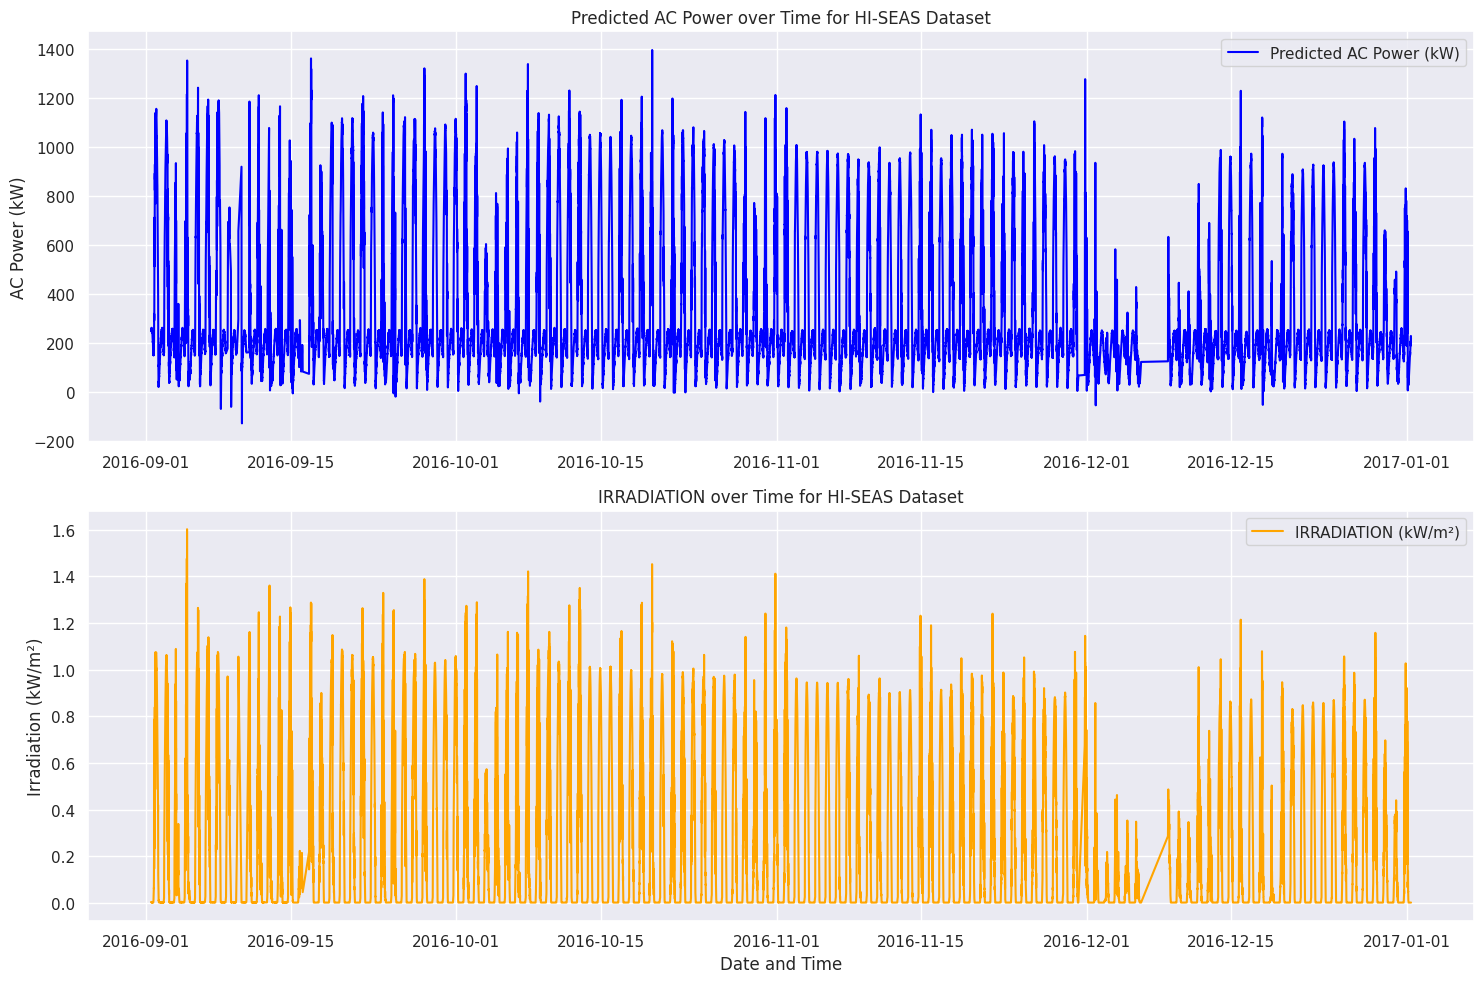

In [ ]:

prediction_index = final_test_df.index[N_LOOKBACK_STEPS: ]

# Create a Series for the predicted AC Power, aligned with the correct timestamps
predicted_ac_power_series = pd.Series(y_pred_HI_SEAS_actual.flatten(), index=prediction_index)

# Plotting
plt.figure(figsize=(15, 10))

# Subplot 1: Predicted AC Power
plt.subplot(2, 1, 1)
plt.plot(predicted_ac_power_series, label='Predicted AC Power (kW)', color='blue')
plt.title('Predicted AC Power over Time for HI-SEAS Dataset')
plt.ylabel('AC Power (kW)')
plt.legend()
plt.grid(True)

# Subplot 2: Irradiation from final_test_df
plt.subplot(2, 1, 2)
# Align irradiation data with the prediction_index for consistent time range
plt.plot(final_test_df['IRRADIATION'][prediction_index], label='IRRADIATION (kW/m²)', color='orange')
plt.title('IRRADIATION over Time for HI-SEAS Dataset')
plt.xlabel('Date and Time')
plt.ylabel('Irradiation (kW/m²)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

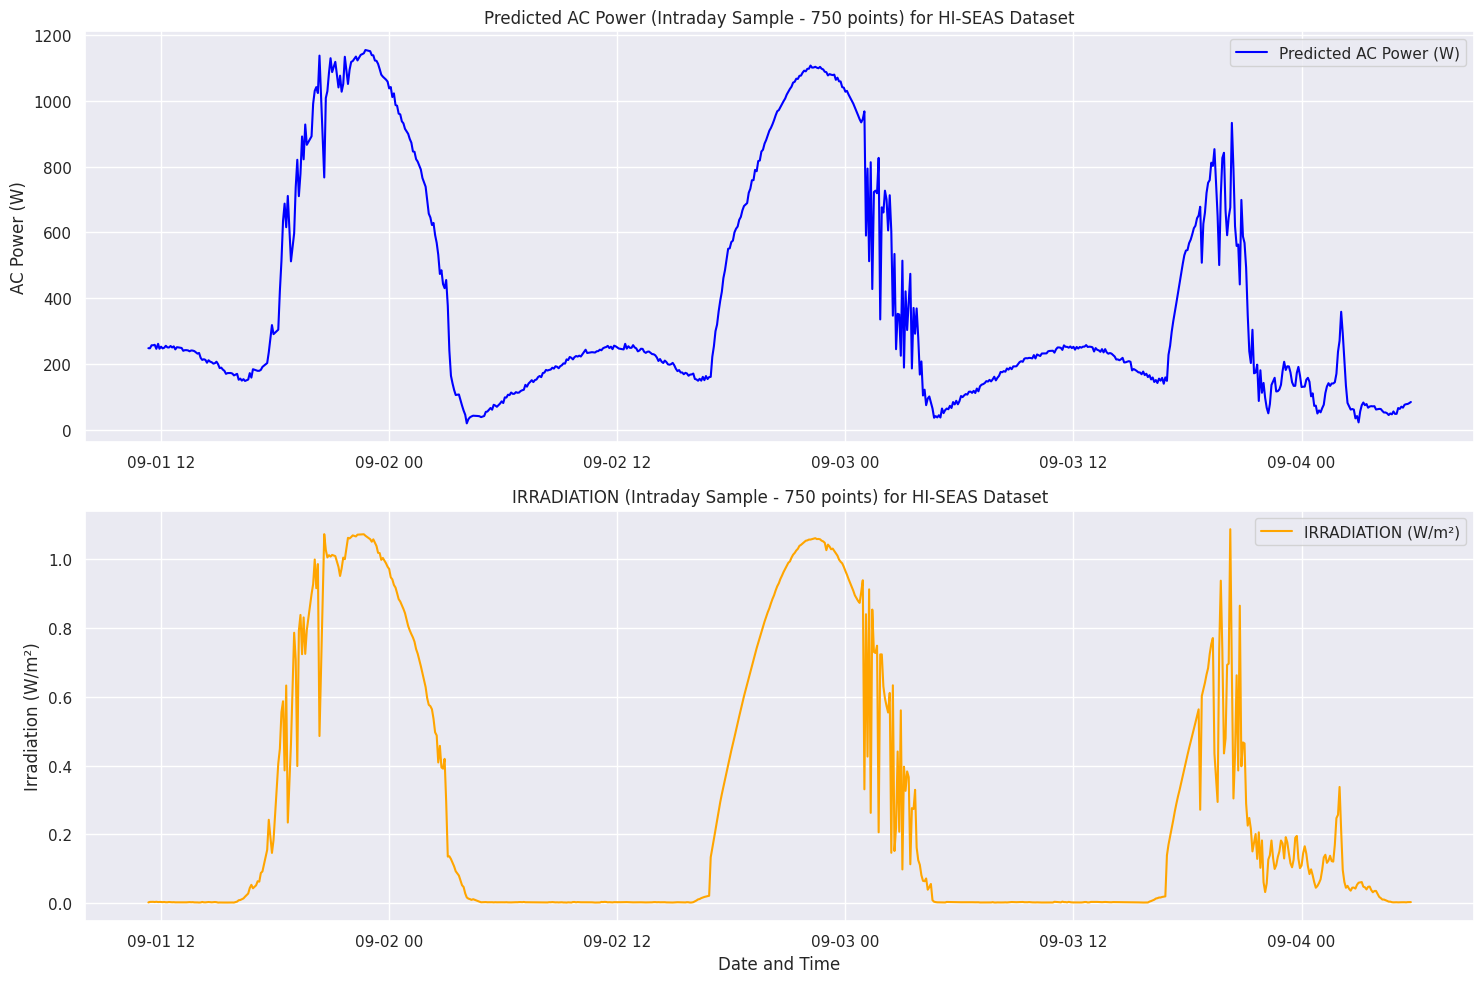

In [ ]:
sample_size = 750

# Take a smaller sample for plotting
sample_predicted_ac_power = predicted_ac_power_series.head(sample_size)
sample_irradiation = final_test_df['IRRADIATION'][sample_predicted_ac_power.index]

plt.figure(figsize=(15, 10))

# Subplot 1: Predicted AC Power (Sampled)
plt.subplot(2, 1, 1)
plt.plot(sample_predicted_ac_power, label='Predicted AC Power (W)', color='blue')
plt.title(f'Predicted AC Power (Intraday Sample - {sample_size} points) for HI-SEAS Dataset')
plt.ylabel('AC Power (W)')
plt.legend()
plt.grid(True)

# Subplot 2: Irradiation (Sampled) from final_test_df
plt.subplot(2, 1, 2)
plt.plot(sample_irradiation, label='IRRADIATION (W/m²)', color='orange')
plt.title(f'IRRADIATION (Intraday Sample - {sample_size} points) for HI-SEAS Dataset')
plt.xlabel('Date and Time')
plt.ylabel('Irradiation (W/m²)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()